In [1]:
import os

!wget --no-verbose --no-cache https://raw.githubusercontent.com/sodeso-nl/ml-utilities/main/contents.txt -P ./ext/
!wget --no-verbose -P ./ext/ --no-cache -i ./ext/contents.txt

2023-08-07 10:20:41 URL:https://raw.githubusercontent.com/sodeso-nl/ml-utilities/main/contents.txt [892/892] -> "./ext/contents.txt" [1]
2023-08-07 10:20:41 URL:https://raw.githubusercontent.com/sodeso-nl/ml-utilities/main/ml_callback.py [8288/8288] -> "./ext/ml_callback.py" [1]
2023-08-07 10:20:42 URL:https://raw.githubusercontent.com/sodeso-nl/ml-utilities/main/ml_internal.py [3032/3032] -> "./ext/ml_internal.py" [1]
2023-08-07 10:20:42 URL:https://raw.githubusercontent.com/sodeso-nl/ml-utilities/main/ml_io.py [2782/2782] -> "./ext/ml_io.py" [1]
2023-08-07 10:20:43 URL:https://raw.githubusercontent.com/sodeso-nl/ml-utilities/main/ml_layer.py [12455/12455] -> "./ext/ml_layer.py" [1]
2023-08-07 10:20:43 URL:https://raw.githubusercontent.com/sodeso-nl/ml-utilities/main/ml_plot.py [26570/26570] -> "./ext/ml_plot.py" [1]
2023-08-07 10:20:44 URL:https://raw.githubusercontent.com/sodeso-nl/ml-utilities/main/ml_util.py [2284/2284] -> "./ext/ml_util.py" [1]
2023-08-07 10:20:44 URL:https://raw

In [2]:
extensions_loaded = False
if not extensions_loaded:
    %load_ext autoreload
    %load_ext tensorboard
    extensions_loaded = True

%autoreload 2
%matplotlib inline

In [3]:
import sys
import os
import random

sys.path.append("./ext")

import ext.ml_callback as mlc
import ext.ml_io as ml_io
import ext.ml_layer as ml_layer
import ext.ml_plot as ml_plot
import ext.ml_util as mlu
import ext.ml_data as ml_data
import ext.ml_view as mlv
import ext.ml_analyze as mla
import ext.ml_shell as mls
import ext.ml_nlp as ml_nlp

import tensorflow as tf
import pandas as pd
import numpy as np

import tensorflow_hub as hub

from keras import Model
from keras import layers
from keras import losses
from keras import optimizers

# Milestone Project 2: SkimLit

The purpose of this notebook is to build an NLP model to make reading medical abstracts easier.

The paper we're replicating (the source of the dataset we'll be using) is available here: https://arxiv.org/abs/1710.06071

And reading through the paper above, we see that the model architecture that they use to achieve their best result is available here: https://aclanthology.org/E17-2110.pdf

## Get Data

Since we'll be replicating the paper above (PubMed 200K RTC), let's download the dataset they used.

We can do so from the authors Github: https://github.com/Franck-Dernoncourt/pubmed-rct

In [9]:
!git clone https://github.com/Franck-Dernoncourt/pubmed-rct.git

Cloning into 'pubmed-rct'...
remote: Enumerating objects: 33, done.
remote: Counting objects: 100% (8/8), done.
remote: Compressing objects: 100% (3/3), done.
remote: Total 33 (delta 5), reused 5 (delta 5), pack-reused 25
Receiving objects: 100% (33/33), 177.08 MiB | 18.06 MiB/s, done.
Resolving deltas: 100% (12/12), done.


In [10]:
!ls pubmed-rct

PubMed_200k_RCT
PubMed_200k_RCT_numbers_replaced_with_at_sign
PubMed_20k_RCT
PubMed_20k_RCT_numbers_replaced_with_at_sign
README.md


In [11]:
# Check wat kind of files are in the PubMed_20K
!ls pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign

dev.txt  test.txt  train.txt


In [12]:
# Start our experiments using the 20K data set with numbers replaced with @ sign.
data_dir = './pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign'

In [13]:
# Check all the filenames in the target directory
filenames = [data_dir + filename for filename in os.listdir(data_dir)]
filenames

['./pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_signdev.txt',
 './pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_signtrain.txt',
 './pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_signtest.txt']

## Preprocess data

Now we've got some text data, it's time to become one with it.

And one of the best ways to become one with the data is to... visualize visualize visualize...

So with that in mind, let's write a function to read in all of the lines of a target text file.

In [14]:
# Create a function to read the lines of a document
def get_lines(filename: str) -> list[str]:
    """
    Reads filename (a text filename) and returns all of the lines of text as a list.
    :param filename:
    :return:
    """
    with open(filename, 'r') as f:
        return f.readlines()

In [15]:
# Let's read in the training lines
train_lines = get_lines(f"{data_dir}/train.txt")
train_lines[:20]

['###24293578\n',
 'OBJECTIVE\tTo investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( OA ) .\n',
 'METHODS\tA total of @ patients with primary knee OA were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .\n',
 'METHODS\tOutcome measures included pain reduction and improvement in function scores and systemic inflammation markers .\n',
 'METHODS\tPain was assessed using the visual analog pain scale ( @-@ mm ) .\n',
 'METHODS\tSecondary outcome measures included the Western Ontario and McMaster Universities Osteoarthritis Index scores , patient global assessment ( PGA ) of the severity of knee OA , and @-min walk distance ( @MWD ) .\n',
 'METHODS\tSerum levels of interleukin @ ( IL-@ ) , IL-@ , tumor necrosis factor ( TNF ) - , and 

In [ ]:
len(train_lines)

210040

Let's think about how we want our data to look...

How I think our data would be best represented...

[{line_number: 0, target: 'BACKGROUND', text: 'Emotional eating is associated with overeating and the development of obesity .', total_lines: 11}]

In [16]:
def preprocess_text_with_line_numbers(filepath: str) -> list[dict]:
    """
    takes in filenanem reads it contents and sorts through each line, extracting things like the target label, the text of the sentence, how many sentences are in the current abstract and what sentence number the target line is.

    :param filepath: the file path
    :return: list of dictionaries
    """
    lines = get_lines(filepath)

    abstract_lines = ""
    abstract_samples = []

    for line in lines:
        if line.startswith('###'):
            abstract_id = line
            abstract_lines = ""
        elif line.isspace():
            abstract_lines_split = abstract_lines.splitlines()

            for abstract_line_number, abstract_line in enumerate(abstract_lines_split):
                target, text = abstract_line.split('\t')

                line_data = {
                    "line_number": abstract_line_number,
                    "target": target,
                    "text": text.lower(),
                    "total_lines": len(abstract_lines_split)
                }
                abstract_samples.append(line_data)
        else:
            abstract_lines += line

    return abstract_samples

In [17]:
%%time
train_samples = preprocess_text_with_line_numbers(f"{data_dir}/train.txt")
val_samples = preprocess_text_with_line_numbers(f"{data_dir}/dev.txt")
test_samples = preprocess_text_with_line_numbers(f"{data_dir}/test.txt")
len(train_samples), len(val_samples), len(test_samples)

CPU times: user 743 ms, sys: 98.3 ms, total: 841 ms
Wall time: 857 ms


(180040, 30212, 30135)

In [ ]:
# Check the first abstract of our training data
train_samples[:14]

[{'line_number': 0,
  'target': 'OBJECTIVE',
  'text': 'to investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( oa ) .',
  'total_lines': 12},
 {'line_number': 1,
  'target': 'METHODS',
  'text': 'a total of @ patients with primary knee oa were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .',
  'total_lines': 12},
 {'line_number': 2,
  'target': 'METHODS',
  'text': 'outcome measures included pain reduction and improvement in function scores and systemic inflammation markers .',
  'total_lines': 12},
 {'line_number': 3,
  'target': 'METHODS',
  'text': 'pain was assessed using the visual analog pain scale ( @-@ mm ) .',
  'total_lines': 12},
 {'line_number': 4,
  'target': 'METHODS',
  'text': 'secondary outcome measures include

Now that our data is in the format of dictionaries, how about we turn it into a dataframe to further visualize it.

In [18]:
train_df = pd.DataFrame(train_samples)
val_df = pd.DataFrame(val_samples)
test_df = pd.DataFrame(test_samples)
train_df.head(14)

,line_number,target,text,total_lines
0,0,OBJECTIVE,to investigate the efficacy of @ weeks of dail...,12
1,1,METHODS,a total of @ patients with primary knee oa wer...,12
2,2,METHODS,outcome measures included pain reduction and i...,12
3,3,METHODS,pain was assessed using the visual analog pain...,12
4,4,METHODS,secondary outcome measures included the wester...,12
5,5,METHODS,"serum levels of interleukin @ ( il-@ ) , il-@ ...",12
6,6,RESULTS,there was a clinically relevant reduction in t...,12
7,7,RESULTS,the mean difference between treatment arms ( @...,12
8,8,RESULTS,"further , there was a clinically relevant redu...",12
9,9,RESULTS,these differences remained significant at @ we...,12


In [ ]:
# Distributions of labels in the training set
train_df.target.value_counts()

target
METHODS        59353
RESULTS        57953
CONCLUSIONS    27168
BACKGROUND     21727
OBJECTIVE      13839
Name: count, dtype: int64

<Axes: ylabel='Frequency'>

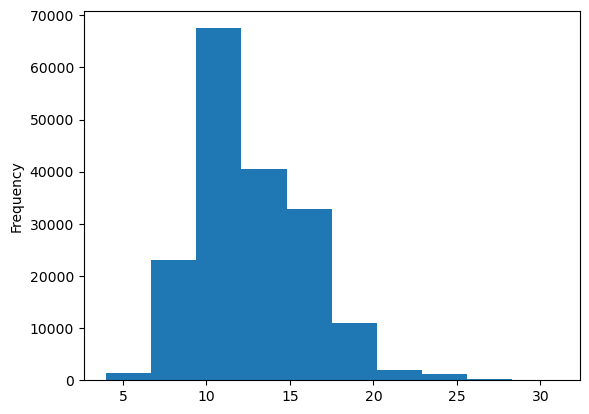

In [ ]:
# Check the length of different lines
train_df.total_lines.plot.hist()

In [19]:
### Get list of sentences
train_sentences = train_df['text'].to_list()
val_sentences = val_df['text'].to_list()
test_sentences = test_df['text'].to_list()
len(train_sentences), len(val_sentences), len(test_sentences)

(180040, 30212, 30135)

In [ ]:
train_sentences[:10]

['to investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( oa ) .',
 'a total of @ patients with primary knee oa were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .',
 'outcome measures included pain reduction and improvement in function scores and systemic inflammation markers .',
 'pain was assessed using the visual analog pain scale ( @-@ mm ) .',
 'secondary outcome measures included the western ontario and mcmaster universities osteoarthritis index scores , patient global assessment ( pga ) of the severity of knee oa , and @-min walk distance ( @mwd ) .',
 'serum levels of interleukin @ ( il-@ ) , il-@ , tumor necrosis factor ( tnf ) - , and high-sensitivity c-reactive protein ( hscrp ) were measured .',
 'there was a clinic

<Axes: ylabel='Frequency'>

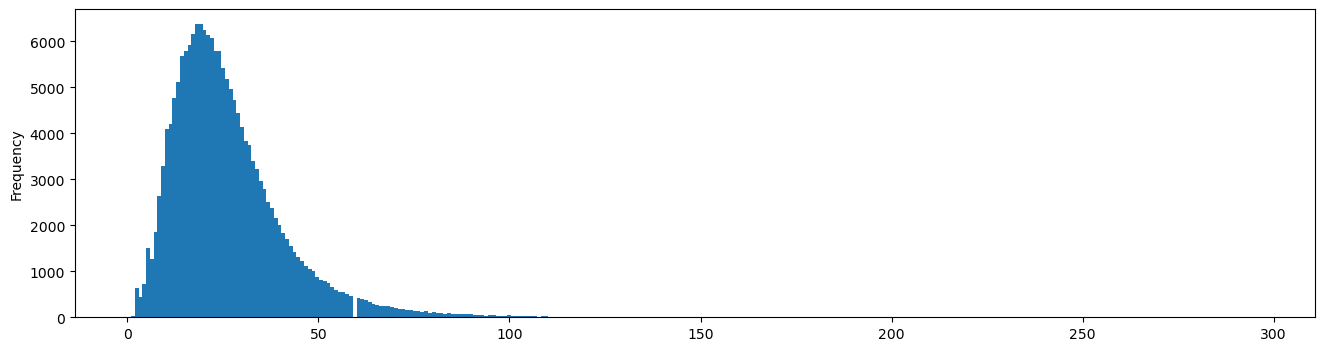

In [ ]:
train_df['text'].map(lambda l: len(l.split())).plot.hist(figsize=(16,4), bins=300)

## Making numeric labels (ML Models require numeric labels)

In [20]:
# One hot encode labels
encoder, train_labels_one_hot, val_labels_one_hot, test_labels_one_hot = \
    ml_data.one_hot_encode_column(
        train_df['target'],
        val_df['target'],
        test_df['target']
    )

train_labels_one_hot

array([[0., 0., 0., 1., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0.],
       ...,
       [0., 0., 0., 0., 1.],
       [0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0.]])

In [ ]:
train_df['target'].to_numpy().ndim, train_df['target'].to_numpy().reshape(-1, 1).ndim

(1, 2)

### Label encode labels

In [21]:
# Extract labels ("target" column) and encode them into integers
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
train_labels_encoded = label_encoder.fit_transform(train_df["target"].to_numpy())
val_labels_encoded = label_encoder.fit_transform(val_df["target"].to_numpy())
test_labels_encoded = label_encoder.fit_transform(test_df["target"].to_numpy())

# check what training labels look like
train_labels_encoded

array([3, 2, 2, ..., 4, 1, 1])

In [22]:
# Get class names and number of classes from Label Encoder instance
num_classes = len(label_encoder.classes_)
class_names = label_encoder.classes_
num_classes, class_names

(5,
 array(['BACKGROUND', 'CONCLUSIONS', 'METHODS', 'OBJECTIVE', 'RESULTS'],
       dtype=object))

In [ ]:
test_df['target'].to_numpy()

array(['BACKGROUND', 'RESULTS', 'RESULTS', ..., 'RESULTS', 'RESULTS',
       'CONCLUSIONS'], dtype=object)

## Starting a series of modelling experiments...

As usual, we're going to be trying out a bunch of different models and seeing which one works best. And as always, we're going to start with a baseline (TF-IDF) Multinomial Naive Bayes classifier.

#Model 0: Getting a baseline

In [23]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline

# Create a pipeline
model_0 = Pipeline([
    ("tf-idf", TfidfVectorizer()),
    ("clf", MultinomialNB())
])

# Fit the pipeline to the training data
model_0.fit(X=train_sentences, y=train_labels_encoded) # We need to use the encoded labels and not the one-hot labels, it expects a sparse result

Pipeline(steps=[('tf-idf', TfidfVectorizer()), ('clf', MultinomialNB())])

In [ ]:
# Evaluate our base pipeline on validation dataset
model_0.score(X=val_sentences, y=val_labels_encoded)

0.7218323844829869

In [ ]:
# Make predictions using our baseline model
model_0_preds = model_0.predict(X=val_sentences)

In [ ]:
model_0_results = ml_plot.table_quality_metrics(y_true=val_labels_encoded, y_pred=model_0_preds)
model_0_results

{'accuracy': 72.1832384482987,
 'f1': 0.6989250353450294,
 'precision': 0.7186466952323352,
 'recall': 0.7218323844829869}

## Preparing our data (the text) for deep sequence model

Before we start building deep models we got to create vectorization and embedding layers

In [24]:
# How long is each sentence on average
average_sentence_length = ml_nlp.calculate_average_word_length(train_sentences)
average_sentence_length

26

In [25]:
# How long of a sentence length covers 95% of examples?
output_sequence_length = ml_nlp.calculate_q_precentile_word_lengths(lines=train_sentences, q=95)
output_sequence_length

55

### Create Text Vectorizer layer

We want to make a layer which maps our text from words to numbers.

In [26]:
# How many words are there in our vocabulary? (taken from table 2 in the paper: https://arxiv.org/pdf/1710.06071.pdf )
max_tokens = ml_nlp.count_unique_words(train_sentences)

text_vectorizer = layers.TextVectorization(
    max_tokens=max_tokens,
    output_sequence_length=output_sequence_length,
    pad_to_max_tokens=True
)

max_tokens

64839

In [27]:
# Adapt TextVectorizer to training sentences
text_vectorizer.adapt(train_sentences)

In [28]:
# Test out text vectorizer on random sentences
target_sentence = random.choice(train_sentences)
len(target_sentence.split()), target_sentence

(40,
 'circi occurred in @ % ( @ of @ ) of the patients with multiple injuries , including @ patients with total cortisol level of less than @ g/dl and @ patients with cortisol of less than @ g/dl .')

In [ ]:
text_vectorizer(target_sentence)

<tf.Tensor: shape=(55,), dtype=int64, numpy=
array([   43,     9,  5993,     5,  2826,     2,  1387,     6,   126,
       10552,   495,   270, 14113,  4225,     6,   469,    97,  1531,
         328,     6,  2542,   425,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0])>

In [ ]:
# How many words in our vocabulary
len(text_vectorizer.get_vocabulary())

64839

In [ ]:
# What are the most common words in our vocabulary
text_vectorizer.get_vocabulary()[:5]

['', '[UNK]', 'the', 'and', 'of']

In [ ]:
# What are the least common words in our vocabulary
text_vectorizer.get_vocabulary()[-5:]

['aanhui', 'aana', 'aainduced', 'aaigroup', 'aachener']

In [ ]:
# Get the config of our TextVectorizer
text_vectorizer.get_config()

{'name': 'text_vectorization',
 'trainable': True,
 'dtype': 'string',
 'batch_input_shape': (None,),
 'max_tokens': 64839,
 'standardize': 'lower_and_strip_punctuation',
 'split': 'whitespace',
 'ngrams': None,
 'output_mode': 'int',
 'output_sequence_length': 55,
 'pad_to_max_tokens': True,
 'sparse': False,
 'ragged': False,
 'vocabulary': None,
 'idf_weights': None,
 'encoding': 'utf-8',
 'vocabulary_size': 64839}

## Create custom text embedding

In [29]:
# Create token embedding layer
token_embedding = layers.Embedding(
    input_dim=max_tokens, # Length of vocabulary
    output_dim=128, # Note: Different embedding sizing results in drastically different number of parameters to train.
    mask_zero=True, # Use masking to handle variable sequence lengths (save space)
    input_length=output_sequence_length,
    name="token_embedding"
)
token_embedding

In [30]:
print(f"Original text: {target_sentence} \
      \n\rEmbedded version:")

# Embedd the random sentence (turn it into dense vectors of fixed size)
sample_embed = token_embedding(text_vectorizer([target_sentence]))
sample_embed, sample_embed.shape

Original text: circi occurred in @ % ( @ of @ ) of the patients with multiple injuries , including @ patients with total cortisol level of less than @ g/dl and @ patients with cortisol of less than @ g/dl .       
Embedded version:


(<tf.Tensor: shape=(1, 55, 128), dtype=float32, numpy=
 array([[[ 0.03972859, -0.02512768,  0.0069553 , ..., -0.01019918,
          -0.03766947, -0.01931163],
         [-0.02475753, -0.01412348,  0.02432611, ..., -0.02108588,
           0.04420025,  0.04177764],
         [-0.02715535,  0.02381268, -0.02467345, ..., -0.01328928,
          -0.03031989,  0.03001416],
         ...,
         [-0.02004081,  0.02331925, -0.000299  , ..., -0.03446408,
          -0.030518  , -0.04942605],
         [-0.02004081,  0.02331925, -0.000299  , ..., -0.03446408,
          -0.030518  , -0.04942605],
         [-0.02004081,  0.02331925, -0.000299  , ..., -0.03446408,
          -0.030518  , -0.04942605]]], dtype=float32)>,
 TensorShape([1, 55, 128]))

## Creating Datasets (making sure our data loads as fast as possible)

https://www.tensorflow.org/guide/data_performance
https://www.tensorflow.org/guide/data

We're going to setup our data to run as fast as possible with the TensorFlow tf.data API, many of the steps here are discussed at length in these two resources.

In [31]:
# Turn our data into TensorFlow datasets.
train_dataset = tf.data.Dataset.from_tensor_slices((train_sentences, train_labels_one_hot))
val_dataset = tf.data.Dataset.from_tensor_slices((val_sentences, val_labels_one_hot))
test_dataset = tf.data.Dataset.from_tensor_slices((test_sentences, test_labels_one_hot))

train_dataset

<_TensorSliceDataset element_spec=(TensorSpec(shape=(), dtype=tf.string, name=None), TensorSpec(shape=(5,), dtype=tf.float64, name=None))>

In [ ]:
train_labels_one_hot.shape, train_labels_one_hot[:1]

((180040, 5), array([[0., 0., 0., 1., 0.]]))

In [32]:
# Take the TensorSliceDataset's and turn them into prefetched datasets.
train_dataset = train_dataset.batch(32).prefetch(buffer_size=tf.data.AUTOTUNE)
val_dataset = val_dataset.batch(32).prefetch(buffer_size=tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(32).prefetch(buffer_size=tf.data.AUTOTUNE)

train_dataset

<_PrefetchDataset element_spec=(TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>

# Model 1: Conv1D model to process sequences

In [ ]:
inputs = layers.Input(shape=(1,), dtype=tf.string)
x = text_vectorizer(inputs)
x = token_embedding(x)
x = layers.Conv1D(filters=64, kernel_size=5, activation="relu", padding="same")(x)
x = layers.GlobalAveragePooling1D()(x) # condense the output from feature vector from conv layer
outputs = layers.Dense(units=num_classes, activation="softmax")(x)

model_1 = Model(inputs, outputs, name="model_0_conv1d")


In [ ]:
model_1.compile(loss=losses.CategoricalCrossentropy(),
                optimizer=optimizers.Adam(),
                metrics=["accuracy"])
model_1.summary()

Model: "model_0_conv1d"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_12 (InputLayer)       [(None, 1)]               0         
                                                                 
 text_vectorization_2 (TextV  (None, 55)               0         
 ectorization)                                                   
                                                                 
 token_embedding (Embedding)  (None, 55, 128)          8704000   
                                                                 
 conv1d_11 (Conv1D)          (None, 55, 64)            41024     
                                                                 
 global_average_pooling1d (G  (None, 64)               0         
 lobalAveragePooling1D)                                          
                                                                 
 dense_11 (Dense)            (None, 5)              

In [ ]:
# Fit the model
model_1_history = model_1.fit(train_dataset,
                              steps_per_epoch=int(0.1*len(train_dataset)), # Only use 10% of the dataset.
                              epochs=3,
                              validation_data=val_dataset,
                              validation_steps=int(0.1*len(val_dataset)) # Only use 10% of the dataset.
                              )

Epoch 1/3
562/562 [==============================] - 17s 29ms/step - loss: 0.9192 - accuracy: 0.6345 - val_loss: 0.6903 - val_accuracy: 0.7374
Epoch 2/3
562/562 [==============================] - 13s 24ms/step - loss: 0.6605 - accuracy: 0.7563 - val_loss: 0.6323 - val_accuracy: 0.7689
Epoch 3/3
562/562 [==============================] - 14s 24ms/step - loss: 0.6207 - accuracy: 0.7752 - val_loss: 0.6002 - val_accuracy: 0.7836


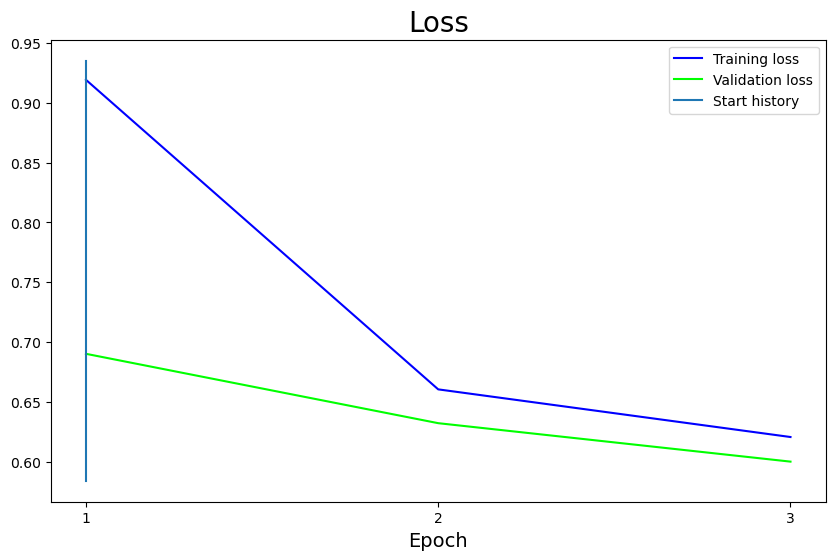

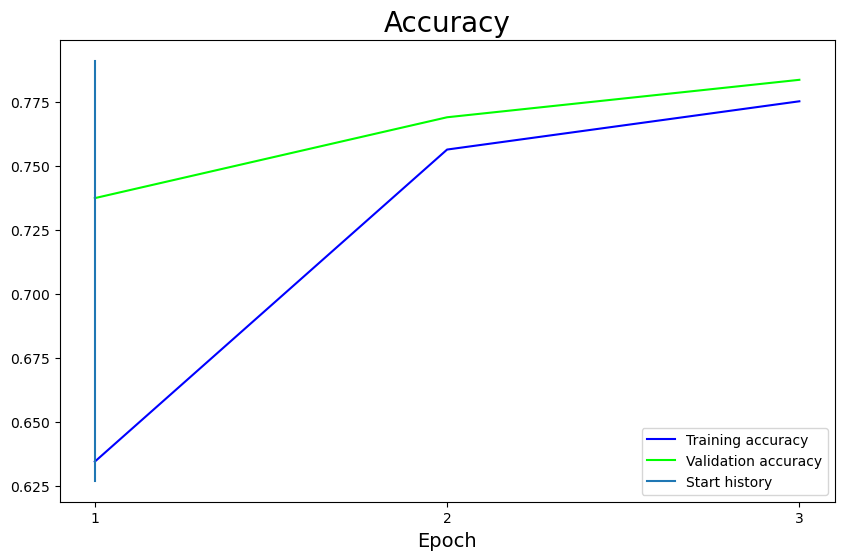

In [ ]:
ml_plot.plot_history(model_1_history)

In [ ]:
# Evaluate dataset
model_1.evaluate(val_dataset)

945/945 [==============================] - 9s 10ms/step - loss: 0.6022 - accuracy: 0.7843


[0.6022104620933533, 0.7842910289764404]

In [ ]:
# Make some predictions (our model predicts prediction probabilities for each class)
model_1_pred_probs = model_1.predict(val_dataset)
model_1_pred_probs, model_1_pred_probs.shape

945/945 [==============================] - 2s 2ms/step


(array([[4.6875861e-01, 1.7808488e-01, 8.2117565e-02, 2.4599461e-01,
         2.5044348e-02],
        [4.4161689e-01, 2.7771834e-01, 1.1038004e-02, 2.6343009e-01,
         6.1967480e-03],
        [1.1417187e-01, 9.0804696e-03, 1.2106519e-03, 8.7552023e-01,
         1.6758249e-05],
        ...,
        [5.1739898e-06, 8.8103535e-04, 1.0072392e-03, 1.6006857e-06,
         9.9810505e-01],
        [4.7998060e-02, 4.2896500e-01, 1.1027917e-01, 5.0902884e-02,
         3.6185491e-01],
        [1.8586907e-01, 6.1356193e-01, 4.1133475e-02, 6.1601561e-02,
         9.7833984e-02]], dtype=float32),
 (30212, 5))

In [ ]:
# Convert pred probs to classes
model_1_preds = tf.argmax(model_1_pred_probs, axis=1)
model_1_preds

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([0, 0, 3, ..., 4, 1, 1])>

In [ ]:
model_1_results = ml_plot.table_quality_metrics(y_true=val_labels_encoded,
                                                y_pred=model_1_preds)
model_1_results

{'accuracy': 78.42910101946246,
 'f1': 0.7815350839058085,
 'precision': 0.7806766153494369,
 'recall': 0.7842910101946247}

In [ ]:
# TODO: Create function to show difference including percentage.
model_0_results

{'accuracy': 72.1832384482987,
 'f1': 0.6989250353450294,
 'precision': 0.7186466952323352,
 'recall': 0.7218323844829869}

## Feature Extaction with pretrained token embeddings

Now lets use pretrained word embeddings from TensorFlow Hun, more specifically the uneiversal sentence encoder.

The paper originally used GloVe embeddings, however, we're going to stick with the later created USE pretrained embeddings.

In [ ]:
# Download pretrained TensorFlow HUB USE
# hub.load(handle="https://tfhub.dev/google/universal-sentence-encoder/4")

In [33]:
# Create Keras Layer using the USE pretrained layer from TensorFlow Hub
tf_hub_embedding_layer = hub.KerasLayer(handle='https://tfhub.dev/google/universal-sentence-encoder/4',
                                        input_shape=[], # Since the input is defined as english text of variable length the layer in itself will make sure it fits
                                        dtype=tf.string,
                                        trainable=False, # we are doing feature extraction so we do not want to train this layer
                                        name='USE'
                                      )

In [ ]:
# Test out the pretrained embedding on some random sentence
tf_hub_embedding_layer([target_sentence])[0][:30]

<tf.Tensor: shape=(30,), dtype=float32, numpy=
array([ 0.03322524,  0.06914259, -0.04557943, -0.07432783, -0.08461034,
       -0.065862  , -0.04518429,  0.01874435, -0.05566745,  0.05537612,
        0.05978589,  0.01924892,  0.00126752,  0.00775402,  0.05653242,
       -0.05496825, -0.07273652,  0.01846563, -0.0026092 ,  0.02249314,
       -0.03160059, -0.03708489, -0.01941463, -0.04779968,  0.04167822,
        0.03381404, -0.03052865,  0.03073542,  0.02906908, -0.00644419],
      dtype=float32)>

# Model 2: Building and fitting future extraction model using pretrained embeddings TensorFlow Hub

In [ ]:
 # Create model using the Sequential API

input = layers.Input(shape=[], dtype=tf.string)
x = tf_hub_embedding_layer(input)
x = layers.Dense(units=128, activation='relu')(x) # Using 64 layers did not achieve as nice results.
output = layers.Dense(units=num_classes, activation='softmax')(x)

model_2 = Model(input, output)

model_2.compile(loss=losses.categorical_crossentropy,
                optimizer=optimizers.Adam(),
                metrics=['accuracy'])

model_2.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_15 (InputLayer)       [(None,)]                 0         
                                                                 
 USE (KerasLayer)            (None, 512)               256797824 
                                                                 
 dense_16 (Dense)            (None, 128)               65664     
                                                                 
 dense_17 (Dense)            (None, 5)                 645       
                                                                 
Total params: 256,864,133
Trainable params: 66,309
Non-trainable params: 256,797,824
_________________________________________________________________


In [ ]:
model_2_history = model_2.fit(train_dataset,
                              epochs=3,
                              steps_per_epoch=int(0.1 * len(train_dataset)),
                              validation_data=val_dataset,
                              validation_steps=int(0.1 * len(val_dataset)))

Epoch 1/3
562/562 [==============================] - 91s 159ms/step - loss: 0.9184 - accuracy: 0.6515 - val_loss: 0.7961 - val_accuracy: 0.6905
Epoch 2/3
562/562 [==============================] - 63s 113ms/step - loss: 0.7698 - accuracy: 0.7005 - val_loss: 0.7539 - val_accuracy: 0.7068
Epoch 3/3
562/562 [==============================] - 62s 111ms/step - loss: 0.7532 - accuracy: 0.7125 - val_loss: 0.7364 - val_accuracy: 0.7161


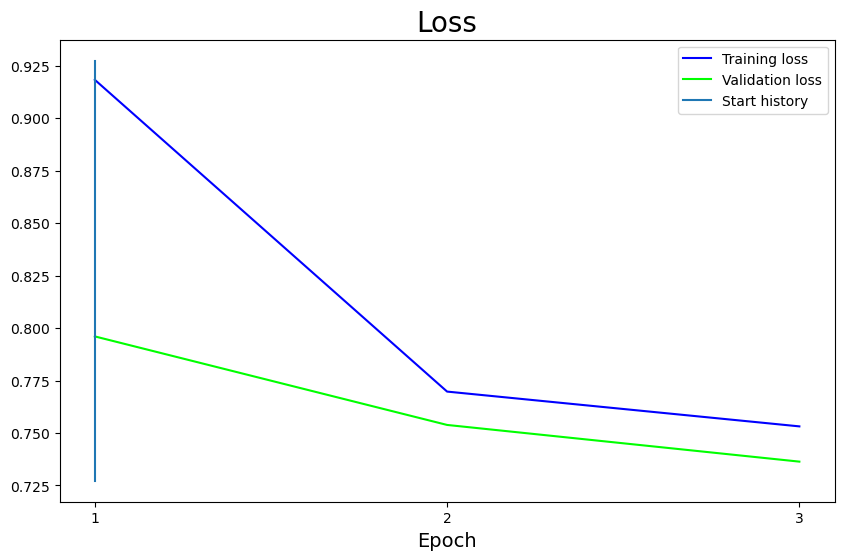

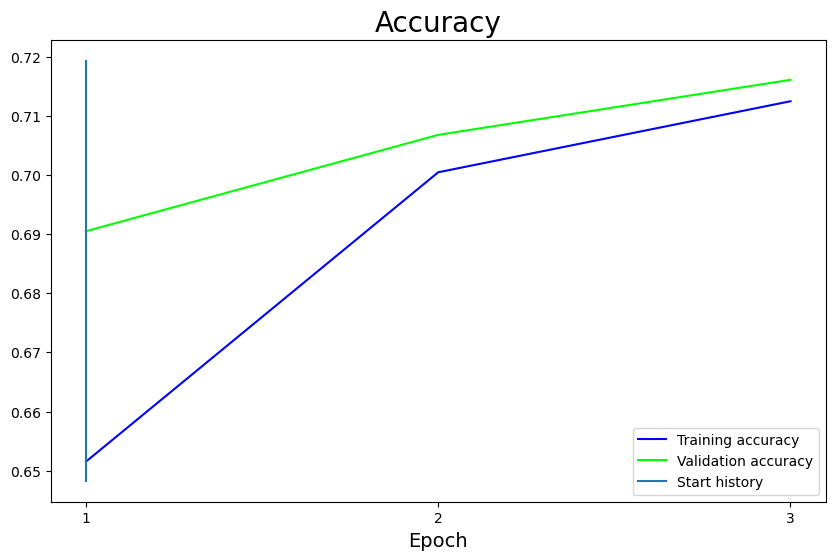

In [ ]:
ml_plot.plot_history(model_2_history)

In [ ]:
# Evaluate the feature extraction model
model_2.evaluate(val_dataset)

945/945 [==============================] - 98s 102ms/step - loss: 0.7405 - accuracy: 0.7150


[0.740524172782898, 0.7150139212608337]

In [ ]:
# Let's make some predictions with the feature extraction model
model_2_pred_probs = model_2.predict(val_dataset)
model_2_preds = tf.argmax(model_2_pred_probs, axis=1)
model_2_preds

945/945 [==============================] - 74s 78ms/step


<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([0, 1, 3, ..., 4, 4, 2])>

In [ ]:
# Calculate results from TensorFlow Hub pretrained embedding
model_2_results = ml_plot.table_quality_metrics(y_true=val_labels_encoded,
                                                y_pred=model_2_preds)
model_2_results

{'accuracy': 70.72024361180988,
 'f1': 0.7033946448967716,
 'precision': 0.7067102137268783,
 'recall': 0.7072024361180987}

In [ ]:
model_0_results

{'accuracy': 72.1832384482987,
 'f1': 0.6989250353450294,
 'precision': 0.7186466952323352,
 'recall': 0.7218323844829869}

# Model 3: Conv1D with character embeddings

The paper which we're replicating states they used a combination of token and character-level embeddings. Previously we've token0level embeddings but we'll need to do similar steps for characters if we want to use char-level embeddings.

## Creating a character-level tokenizer

In [ ]:
train_sentences[:5]

['to investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( oa ) .',
 'a total of @ patients with primary knee oa were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .',
 'outcome measures included pain reduction and improvement in function scores and systemic inflammation markers .',
 'pain was assessed using the visual analog pain scale ( @-@ mm ) .',
 'secondary outcome measures included the western ontario and mcmaster universities osteoarthritis index scores , patient global assessment ( pga ) of the severity of knee oa , and @-min walk distance ( @mwd ) .']

In [43]:
# make function to split sentences into characters
def split_chars(text: str):
    return " ".join(list(text))

# Text splitting non-character level sequence into characters
split_chars(target_sentence)

NameError: ignored

In [35]:
# Split sequence-level data splits into character level data splits
train_chars = [split_chars(sentence) for sentence in train_sentences]
val_chars = [split_chars(sentence) for sentence in val_sentences]
test_chars = [split_chars(sentence) for sentence in test_sentences]
train_chars[:5]

['t o   i n v e s t i g a t e   t h e   e f f i c a c y   o f   @   w e e k s   o f   d a i l y   l o w - d o s e   o r a l   p r e d n i s o l o n e   i n   i m p r o v i n g   p a i n   ,   m o b i l i t y   ,   a n d   s y s t e m i c   l o w - g r a d e   i n f l a m m a t i o n   i n   t h e   s h o r t   t e r m   a n d   w h e t h e r   t h e   e f f e c t   w o u l d   b e   s u s t a i n e d   a t   @   w e e k s   i n   o l d e r   a d u l t s   w i t h   m o d e r a t e   t o   s e v e r e   k n e e   o s t e o a r t h r i t i s   (   o a   )   .',
 'a   t o t a l   o f   @   p a t i e n t s   w i t h   p r i m a r y   k n e e   o a   w e r e   r a n d o m i z e d   @ : @   ;   @   r e c e i v e d   @   m g / d a y   o f   p r e d n i s o l o n e   a n d   @   r e c e i v e d   p l a c e b o   f o r   @   w e e k s   .',
 'o u t c o m e   m e a s u r e s   i n c l u d e d   p a i n   r e d u c t i o n   a n d   i m p r o v e m e n t   i n   f u n c t i o n   s c o r e s   a 

In [36]:
# Find what character length covers 95% of sequences
output_sequence_char_length = ml_nlp.calculate_q_precentile_character_lengths(train_sentences)
num_char_tokens, _ = ml_nlp.count_unique_chars(train_sentences)

output_sequence_char_length, num_char_tokens, str(_)

(290,
 27,
 "{'x', 'p', 's', 'f', 'c', 'h', 'q', 'u', 'd', 'z', ' ', 't', 'b', 'r', 'e', 'o', 'j', 'w', 'v', 'k', 'i', 'm', 'a', 'g', 'l', 'n', 'y'}")

In [37]:
# Create char-level token vectorizer instance
char_vectorizer = layers.TextVectorization(max_tokens=num_char_tokens + 1, # Add one for OOV, space is already included
                                           output_sequence_length=output_sequence_char_length,
                                           standardize="lower_and_strip_punctuation",
                                           name="char_vectorizer")

In [38]:
# Adapt character vectorizer to training characters
char_vectorizer.adapt(train_chars)

In [39]:
character_vocabulary = char_vectorizer.get_vocabulary()
print(f"Number of different characters in vocabulary: {len(character_vocabulary)}")
print(f"Characters: {character_vocabulary}")

Number of different characters in vocabulary: 28
Characters: ['', '[UNK]', 'e', 't', 'i', 'a', 'n', 'o', 'r', 's', 'd', 'c', 'l', 'h', 'p', 'm', 'u', 'f', 'g', 'y', 'w', 'v', 'b', 'k', 'x', 'z', 'q', 'j']


In [40]:
# Test out character vectorization
target_chars = random.choice(train_chars)
print(f"Value of target_chars:\n {target_chars}")
print(f"\nLength of target_chars : {len(target_chars.split())}")

vectorized_chars = char_vectorizer([target_chars])
print(f"\nVectorized of target_chars : {vectorized_chars}")
print(f"\nLength of vectorized target_chars : {len(vectorized_chars[0])}")

Value of target_chars:
 a n a l g e s i c s   .

Length of target_chars : 11

Vectorized of target_chars : [[ 5  6  5 12 18  2  9  4 11  9  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0 

## Creating a character level embedding

In [41]:
# Create character embedding layer
char_embedding = layers.Embedding(
    input_dim=len(char_vectorizer.get_vocabulary()), # Length of vocabulary
    output_dim=25, # Note: Character embedding (how many features per character)
    mask_zero=True, # Use masking to handle variable sequence lengths (save space)
    name="char_embedding"
)

In [42]:
# Test our character embedding layer
print(f"Charified text (length: {len(target_chars)}):\n {target_chars}")
target_chars_embedded = char_embedding(char_vectorizer([target_chars]))
print(f"Embedded charified text (after vectorization):\n {target_chars_embedded}")
print(f"Embedded charified text shape: {target_chars_embedded.shape}")

Charified text (length: 23):
 a n a l g e s i c s   .
Embedded charified text (after vectorization):
 [[[ 0.02519265  0.02080318 -0.00327308 ...  0.03390392  0.03523476
    0.01007408]
  [-0.0167226  -0.03279455 -0.00307591 ...  0.03843582 -0.01670368
    0.00261464]
  [ 0.02519265  0.02080318 -0.00327308 ...  0.03390392  0.03523476
    0.01007408]
  ...
  [ 0.03028245 -0.03723834 -0.00878812 ...  0.01770805 -0.01413312
   -0.02476149]
  [ 0.03028245 -0.03723834 -0.00878812 ...  0.01770805 -0.01413312
   -0.02476149]
  [ 0.03028245 -0.03723834 -0.00878812 ...  0.01770805 -0.01413312
   -0.02476149]]]
Embedded charified text shape: (1, 290, 25)


## Build the model

In [ ]:
inputs = layers.Input(shape=(1,), dtype=tf.string)
x = char_vectorizer(inputs)
x = char_embedding(x)
x = layers.Conv1D(filters=64, kernel_size=5, activation="relu", padding="same")(x)
x = layers.GlobalMaxPooling1D()(x) # condense the output from feature vector from conv layer
outputs = layers.Dense(units=num_classes, activation="softmax")(x)

model_3 = Model(inputs, outputs, name="model_4_conv1d")

In [ ]:
model_3.compile(loss=losses.CategoricalCrossentropy(),
                optimizer=optimizers.Adam(),
                metrics=['accuracy'])
model_3.summary()

Model: "model_4_conv1d"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_19 (InputLayer)       [(None, 1)]               0         
                                                                 
 char_vectorizer (TextVector  (None, 290)              0         
 ization)                                                        
                                                                 
 char_embedding (Embedding)  (None, 290, 25)           700       
                                                                 
 conv1d_15 (Conv1D)          (None, 290, 64)           8064      
                                                                 
 global_max_pooling1d_11 (Gl  (None, 64)               0         
 obalMaxPooling1D)                                               
                                                                 
 dense_21 (Dense)            (None, 5)              

In [43]:
# Create datasets with batching and prefetching
train_chars_dataset = tf.data.Dataset.from_tensor_slices((train_chars, train_labels_one_hot))
val_chars_dataset = tf.data.Dataset.from_tensor_slices((val_chars, val_labels_one_hot))
test_chars_dataset = tf.data.Dataset.from_tensor_slices((test_chars, test_labels_one_hot))

train_chars_dataset = train_chars_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
val_chars_dataset = val_chars_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
test_chars_dataset = test_chars_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

train_chars_dataset

<_PrefetchDataset element_spec=(TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>

In [ ]:
# Fit the model on characters only
model_3_history = model_3.fit(train_chars_dataset,
                              steps_per_epoch=int(0.1 * len(train_chars_dataset)),
                              validation_data=val_chars_dataset,
                              validation_steps=int(0.1 * len(val_chars_dataset)),
                              epochs=3)

Epoch 1/3
562/562 [==============================] - 24s 41ms/step - loss: 1.2574 - accuracy: 0.4813 - val_loss: 1.1133 - val_accuracy: 0.5502
Epoch 2/3
562/562 [==============================] - 21s 37ms/step - loss: 1.0815 - accuracy: 0.5574 - val_loss: 1.0087 - val_accuracy: 0.5918
Epoch 3/3
562/562 [==============================] - 22s 39ms/step - loss: 0.9982 - accuracy: 0.6025 - val_loss: 0.9418 - val_accuracy: 0.6270


In [ ]:
# Make predictions with character model 3
model_3_pred_props = model_3.predict(val_chars_dataset)
model_3_preds = tf.argmax(model_3_pred_props, axis=1)
model_3_preds

945/945 [==============================] - 3s 3ms/step


<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([1, 3, 3, ..., 4, 2, 1])>

In [ ]:
model_3_results = ml_plot.table_quality_metrics(y_true=val_labels_encoded, y_pred=model_3_preds)
model_3_results

{'accuracy': 62.48510525618959,
 'f1': 0.6189808492306346,
 'precision': 0.6305312243908151,
 'recall': 0.6248510525618959}

# Model 4: Combining pretrained token embeddings + character embeddings (hybrid embeddings)

1. Create a token level embedding model (similar to model_1)
2. Create a character level model (similar to model_3 with a slight modification)
3. Combine 1 and 2 with a concatenate layer (layers.Concatenate)
4. Build a series of output layers on top of 3 similar to figure 1 section 4.2 of the paper https://aclanthology.org/E17-2110.pdf)
5. Construct a model which takes token and character-level sequences as input and produces sequence label probabilities as output.

In [44]:
# 1. Setup token inputs/model
token_inputs = layers.Input(shape=[], dtype=tf.string, name="token-input")
token_embeddings = tf_hub_embedding_layer(token_inputs)
token_output = layers.Dense(units=128, activation="relu")(token_embeddings)
token_model = tf.keras.Model(inputs=token_inputs, outputs=token_output)

# 2. Setup charaxcter inputs/models
character_inputs = layers.Input(shape=[], dtype=tf.string, name="character-input")
character_vectors = char_vectorizer(character_inputs)
character_embeddings = char_embedding(character_vectors)
character_bi_lstm = layers.Bidirectional(layers.LSTM(units=24))(character_embeddings) # bi-lstm as shown in Figure 1 (https://aclanthology.org/E17-2110.pdf)
characer_model = tf.keras.Model(inputs=character_inputs, outputs=character_bi_lstm)

# 3. Concatentate token and character inputs (create hybrid token embedding)
token_character_concat = layers.Concatenate(name="token_character_hybrid")([token_model.output, characer_model.output])

# 4. Create output layers adding in dropout (this is discussed in section 4.2 of paper (https://aclanthology.org/E17-2110.pdf)
combined_dropout = layers.Dropout(rate=.5)(token_character_concat)
combined_dense = layers.Dense(units=128, activation="relu")(combined_dropout)
final_dropout = layers.Dropout(rate=.5)(combined_dense)
output = layers.Dense(units=5, activation="softmax")(final_dropout)

# 5. Construct model with character and token inputs
model_4 = tf.keras.Model(inputs=[token_model.inputs,characer_model.inputs], outputs=output, name="model_4_token_and_character_embeddings")

In [45]:
# Get a summary
model_4.summary()

Model: "model_4_token_and_character_embeddings"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 character-input (InputLayer)   [(None,)]            0           []                               
                                                                                                  
 token-input (InputLayer)       [(None,)]            0           []                               
                                                                                                  
 char_vectorizer (TextVectoriza  (None, 290)         0           ['character-input[0][0]']        
 tion)                                                                                            
                                                                                                  
 USE (KerasLayer)               (None, 512)          25679782

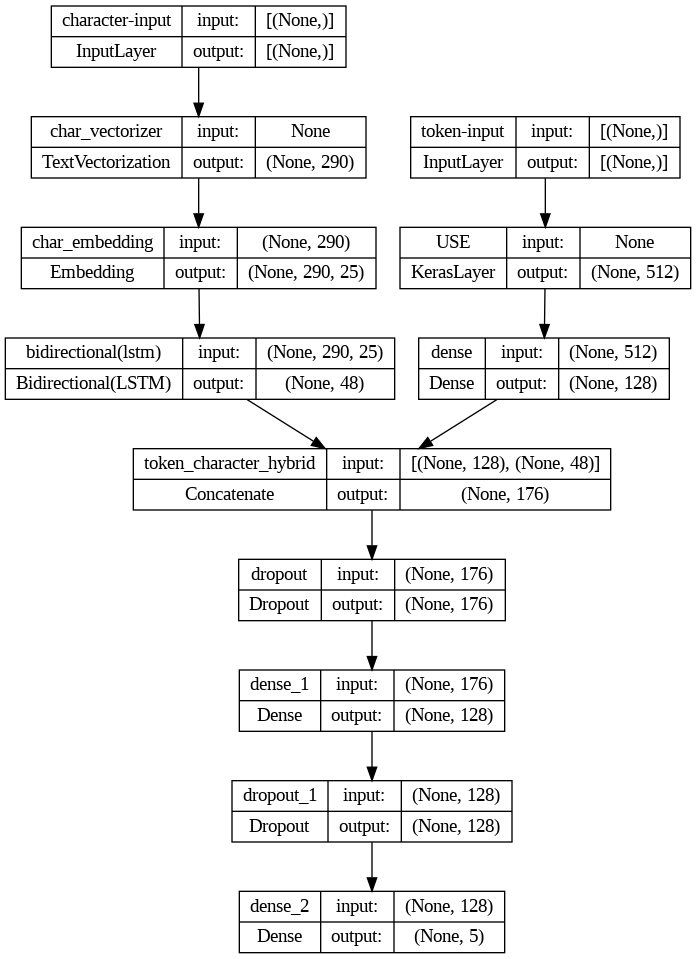

In [46]:
# Plot hybrid token and character model
from keras.utils import plot_model
plot_model(model_4, show_shapes=True)

In [47]:
# Compile token / character model
model_4.compile(loss=losses.CategoricalCrossentropy(),
                optimizer=optimizers.Adam(),
                metrics=["accuracy"])

## Combining token and character data into a tf.Dataset

In [48]:
# Important the order must be the same as the order specified in the inputs of model_4 (token then character)
train_token_character_data = tf.data.Dataset.from_tensor_slices((train_sentences, train_chars)) # Make data
train_token_character_label = tf.data.Dataset.from_tensor_slices(train_labels_one_hot) # Make labels
train_token_character_dataset = tf.data.Dataset.zip((train_token_character_data, train_token_character_label)) # Combine data and label
train_token_character_dataset = train_token_character_dataset.batch(32).prefetch(tf.data.AUTOTUNE) # Setup batching / prefetching

val_token_character_data = tf.data.Dataset.from_tensor_slices((val_sentences, val_chars)) # Make data
val_token_character_label = tf.data.Dataset.from_tensor_slices(val_labels_one_hot) # Make labels
val_token_character_dataset = tf.data.Dataset.zip((val_token_character_data, val_token_character_label)) # Combine data and label
val_token_character_dataset = val_token_character_dataset.batch(32).prefetch(tf.data.AUTOTUNE) # Setup batching / prefetching

In [ ]:
# Check our training char and token embedding dataset
train_token_character_dataset, val_token_character_dataset

(<_PrefetchDataset element_spec=((TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>,
 <_PrefetchDataset element_spec=((TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>)

## Fitting a model on token and character sequences

In [49]:
model_4_history = model_4.fit(train_token_character_dataset,
                              steps_per_epoch=int(.1 * len(train_token_character_dataset)),
                              validation_data=val_token_character_dataset,
                              validation_steps=int(.1 * len(val_token_character_dataset)),
                              epochs=3)

Epoch 1/3
562/562 [==============================] - 51s 62ms/step - loss: 0.9820 - accuracy: 0.6112 - val_loss: 0.7721 - val_accuracy: 0.6968
Epoch 2/3
562/562 [==============================] - 34s 60ms/step - loss: 0.8003 - accuracy: 0.6894 - val_loss: 0.7244 - val_accuracy: 0.7271
Epoch 3/3
562/562 [==============================] - 29s 52ms/step - loss: 0.7769 - accuracy: 0.7037 - val_loss: 0.7109 - val_accuracy: 0.7324


In [50]:
# Evaluate on the whole validation set
model_4.evaluate(val_token_character_dataset)

945/945 [==============================] - 25s 26ms/step - loss: 0.7156 - accuracy: 0.7279


[0.7156113982200623, 0.727856457233429]

In [51]:
# Make predictions using the token-character model hybrid
model_4_pred_props = model_4.predict(val_token_character_dataset)
model_4_preds = tf.argmax(model_4_pred_props, axis=1)
model_4_results = ml_plot.table_quality_metrics(y_true=val_labels_encoded, y_pred=model_4_preds)
model_4_results

945/945 [==============================] - 25s 22ms/step


{'accuracy': 72.7856480868529,
 'f1': 0.7266156568492785,
 'precision': 0.7297875201058328,
 'recall': 0.727856480868529}

## Model 5: Transfer learning with pretrained token embedding + character embedding + positional embeddings

In [53]:
train_df.head()

,line_number,target,text,total_lines
0,0,OBJECTIVE,to investigate the efficacy of @ weeks of dail...,12
1,1,METHODS,a total of @ patients with primary knee oa wer...,12
2,2,METHODS,outcome measures included pain reduction and i...,12
3,3,METHODS,pain was assessed using the visual analog pain...,12
4,4,METHODS,secondary outcome measures included the wester...,12


> **Note**: Any engineered features used to train the model need to be available during test-time. In our case, line-numbers and total lines are available.

### Positional embeddings

In [55]:
# How many different line nubmers are there.
train_df['line_number'].value_counts()

0     15000
1     15000
2     15000
3     15000
4     14992
5     14949
6     14758
7     14279
8     13346
9     11981
10    10041
11     7892
12     5853
13     4152
14     2835
15     1861
16     1188
17      751
18      462
19      286
20      162
21      101
22       66
23       33
24       22
25       14
26        7
27        4
28        3
29        1
30        1
Name: line_number, dtype: int64

<Axes: ylabel='Frequency'>

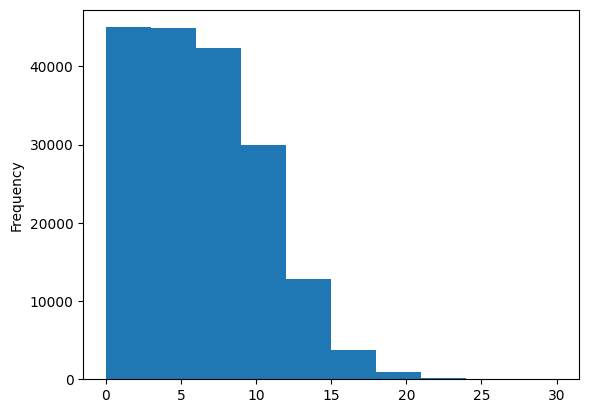

In [56]:
# Check the distribution of "line_number" column
train_df['line_number'].plot.hist()

In [57]:
# Use TensorFlow to create one-hot encoded tensors of our line number column. Reason to use one-hot encoding is to not give the impression that line number 2 is more important then line number 1 using for example MinMaxScaler.
# TODO: Change the ml_data one_hot_encode_column to use tf.one_hot and apply optional depth.
train_line_numbers_one_hot = tf.one_hot(train_df['line_number'].to_numpy(), depth=15)
val_line_numbers_one_hot = tf.one_hot(val_df['line_number'].to_numpy(), depth=15)
test_line_numbers_one_hot = tf.one_hot(test_df['line_number'].to_numpy(), depth=15)
train_line_numbers_one_hot[:10], train_line_numbers_one_hot.shape

(<tf.Tensor: shape=(10, 15), dtype=float32, numpy=
 array([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.]],
       dtype=float32)>,
 TensorShape([180040, 15]))

Now we've encoded our line numbers feature, let's do the same for our total line numbers.

In [69]:
train_df['total_lines'].value_counts()

12    24468
11    23639
13    22113
10    19400
14    18438
15    14610
9     12285
16    10768
8      7464
17     7429
18     5202
7      3353
19     3344
20     2480
21     1281
6      1146
22      770
23      759
24      264
5       215
25      200
26      182
27       81
29       58
4        32
31       31
28       28
Name: total_lines, dtype: int64

<Axes: ylabel='Frequency'>

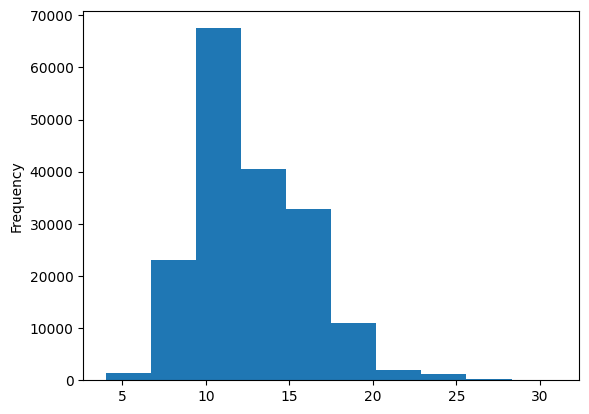

In [66]:
# Check the distributions of the total_lines
train_df['total_lines'].plot.hist()

In [72]:
# Check the coverage of  a total_lines value of 20
np.percentile(train_df['total_lines'], 98)

21.0

In [73]:
# Use TensorFlow to create one-hot-encoded tensors out of our 'total_lines' feature.
train_total_lines_one_hot = tf.one_hot(train_df['total_lines'].to_numpy(), depth=20)
val_total_lines_one_hot = tf.one_hot(val_df['total_lines'].to_numpy(), depth=20)
test_total_lines_one_hot = tf.one_hot(test_df['total_lines'].to_numpy(), depth=20)
train_total_lines_one_hot[:10], train_total_lines_one_hot.shape

(<tf.Tensor: shape=(10, 20), dtype=float32, numpy=
 array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1

### Building a tribrid embedding model

1. Create a token level model
2. Create a character level model
3. Create a model for the line_number feature
4. Create a model for the total_lines feature
5. Combine the outputs of 1 and 2 using tf.keras.layers.Concatenate
6. Combine the outputs of 3, 4 and 5 using tf.keras.layers.Concatenate
7. Create an output layer to accept the tribred embedding and output label probabilities
8. Combine the inputs of 1, 2, 3 and 4 and the outputs of 7 into a tf.keras.Model.

In [89]:
# 1. Token model
token_inputs = layers.Input(shape=[], dtype=tf.string, name='token_inputs')
token_embeddings = tf_hub_embedding_layer(token_inputs)
token_outputs = layers.Dense(units=128, activation='relu')(token_embeddings)
token_model = tf.keras.Model(inputs=token_inputs, outputs=token_outputs, name='token_model')

# 2. Character model
character_inputs = layers.Input(shape=(1,), dtype=tf.string, name='character_inputs')
character_vectors = char_vectorizer(character_inputs)
character_embeddings = char_embedding(character_vectors)
character_bi_lstm = layers.Bidirectional(layers.LSTM(24))(character_embeddings)
character_model = tf.keras.Model(inputs=character_inputs, outputs=character_bi_lstm, name='character_model')

# 3. Line number model
line_number_inputs = layers.Input(shape=(15,), dtype=tf.float32, name='line_number_input')
line_number_outputs = layers.Dense(units=32, activation='relu')(line_number_inputs)
line_number_model = tf.keras.Model(inputs=line_number_inputs, outputs=line_number_outputs, name='line_number_model')

# 4. Total lines model
total_lines_inputs = layers.Input(shape=(20,), dtype=tf.float32, name='total_lines_input')
total_lines_outputs = layers.Dense(units=32, activation='relu')(total_lines_inputs)
total_lines_model = tf.keras.Model(inputs=total_lines_inputs, outputs=total_lines_outputs, name='total_lines_model')

# 5. Combine token and character outputs into a hybrid embedding
combined_embeddings = layers.Concatenate(name='combined_embeddings')([token_model.output,
                                                                      character_model.output])

# Add a dropout layer between the combined embeddings.
dense_combined_embeddings = layers.Dense(units=256, activation='relu')(combined_embeddings)
dropout_combined_embeddings = layers.Dropout(.5)(dense_combined_embeddings)

# 6. Combine positional embeddings with combined token and character embeddings
tribrid_embeddings = layers.Concatenate(name='char_token_positional_embedding')([line_number_model.output,
                                                                    total_lines_model.output,
                                                                    dropout_combined_embeddings])

# 7. Create output layer
output_layer = layers.Dense(units=num_classes, activation='softmax', name='output_layer')(tribrid_embeddings)

# 8. Put together model with all kinds of inputs (order needs to take account for concatenations)
model_5 = tf.keras.Model(inputs=[line_number_model.input,
                                 total_lines_model.input,
                                 token_model.input,
                                 character_model.input,
                                 ],
                         outputs=output_layer,
                         name="model_5")


In [90]:
# Get a summary of our tribrid embedding model
model_5.summary()

Model: "model_5"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 character_inputs (InputLayer)  [(None, 1)]          0           []                               
                                                                                                  
 token_inputs (InputLayer)      [(None,)]            0           []                               
                                                                                                  
 char_vectorizer (TextVectoriza  (None, 290)         0           ['character_inputs[0][0]']       
 tion)                                                                                            
                                                                                                  
 USE (KerasLayer)               (None, 512)          256797824   ['token_inputs[0][0]']     

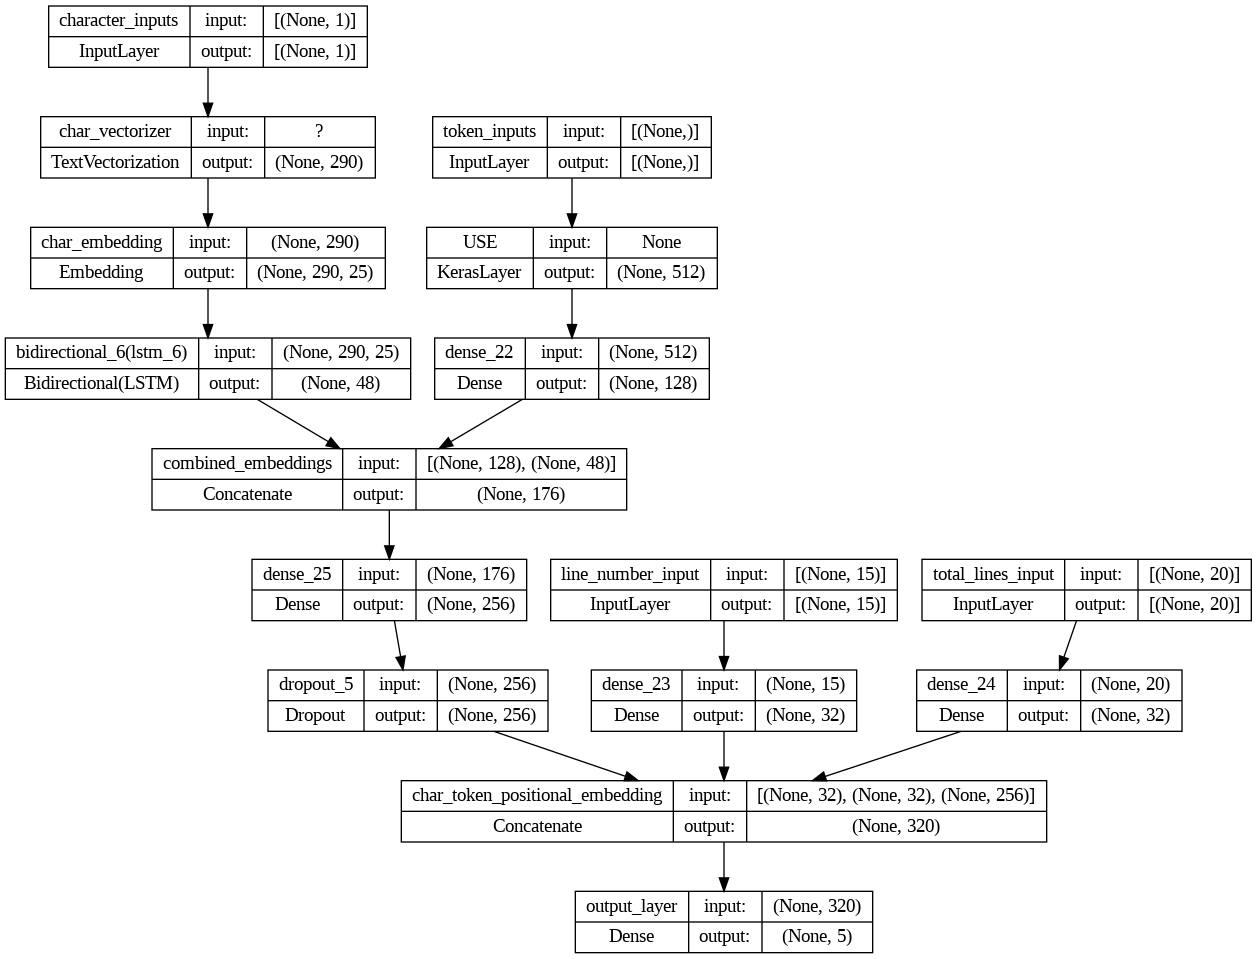

In [91]:
plot_model(model_5, show_shapes=True)

What is label smoothing?

For example if our model gets to confident on a single class (e.g. its prediction probabiliy is really high), it may get stuck on that class and not consider other classes...

Really confident: `[0.0, 0.0, 1.0, 0.0, 0.0]` (100% confident it is the 3rd class)

What label smoothing does is it assigns some of the value from the highest prediction to other classes, in turn, hopefully improving generalization: `[0.1, 0.1, 0.96, 0.1, 0.1]`

https://www.tensorflow.org/api_docs/python/tf/keras/losses/CategoricalCrossentropy

In [104]:
# Compile token, chararacer and possitional embedding
model_5.compile(loss=losses.CategoricalCrossentropy(label_smoothing=0.2), # Helps to prevent overfitting.
                optimizer=optimizers.Adam(),
                metrics=['accuracy'])

### Create tribrid embedding datasets

In [95]:
#
# Create training datasets (with all four kinds of input data)
#
# Create X
train_char_token_pos_data = tf.data.Dataset.from_tensor_slices((train_line_numbers_one_hot,
                                                                train_total_lines_one_hot,
                                                                train_sentences,
                                                                train_chars))

# Create Y
train_char_token_pos_label = tf.data.Dataset.from_tensor_slices(train_labels_one_hot)

# Combine both x and y datasets into a new dataset.
train_char_token_pos_dataset = tf.data.Dataset.zip((train_char_token_pos_data, train_char_token_pos_label))

# Add batching and prefching
train_char_token_pos_dataset = train_char_token_pos_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

#
# Create validation datasets (with all four kinds of input data)
#
# Create X
val_char_token_pos_data = tf.data.Dataset.from_tensor_slices((val_line_numbers_one_hot,
                                                              val_total_lines_one_hot,
                                                              val_sentences,
                                                              val_chars))

# Create y
val_char_token_pos_label = tf.data.Dataset.from_tensor_slices((val_labels_one_hot))

# Combine both x and y datasets into a new dataset.
val_char_token_pos_dataset = tf.data.Dataset.zip((val_char_token_pos_data, val_char_token_pos_label))

# Add batching and prefetch
val_char_token_pos_dataset = val_char_token_pos_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

In [98]:
# Check input shapes

# Ordert is:
# 15 for One-hot line_numbers
# 20 for One-hot total_lines
# [] for sentences
# [] for characters
# 5 for number of classes

train_char_token_pos_dataset, val_char_token_pos_dataset

(<_PrefetchDataset element_spec=((TensorSpec(shape=(None, 15), dtype=tf.float32, name=None), TensorSpec(shape=(None, 20), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>,
 <_PrefetchDataset element_spec=((TensorSpec(shape=(None, 15), dtype=tf.float32, name=None), TensorSpec(shape=(None, 20), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>)

Fitting, evaluating and making predictions with our tribrid model

In [105]:
# Fit the model
model_5_history = model_5.fit(train_char_token_pos_dataset,
                              steps_per_epoch=int(.1 * len(train_char_token_pos_dataset)),
                              epochs=3,
                              validation_data=val_char_token_pos_dataset,
                              validation_steps=int(.1 * len(val_char_token_pos_dataset)))

Epoch 1/3
562/562 [==============================] - 53s 77ms/step - loss: 1.0956 - accuracy: 0.7251 - val_loss: 0.9856 - val_accuracy: 0.8075
Epoch 2/3
562/562 [==============================] - 52s 93ms/step - loss: 0.9681 - accuracy: 0.8145 - val_loss: 0.9525 - val_accuracy: 0.8225
Epoch 3/3
562/562 [==============================] - 42s 74ms/step - loss: 0.9508 - accuracy: 0.8219 - val_loss: 0.9378 - val_accuracy: 0.8324


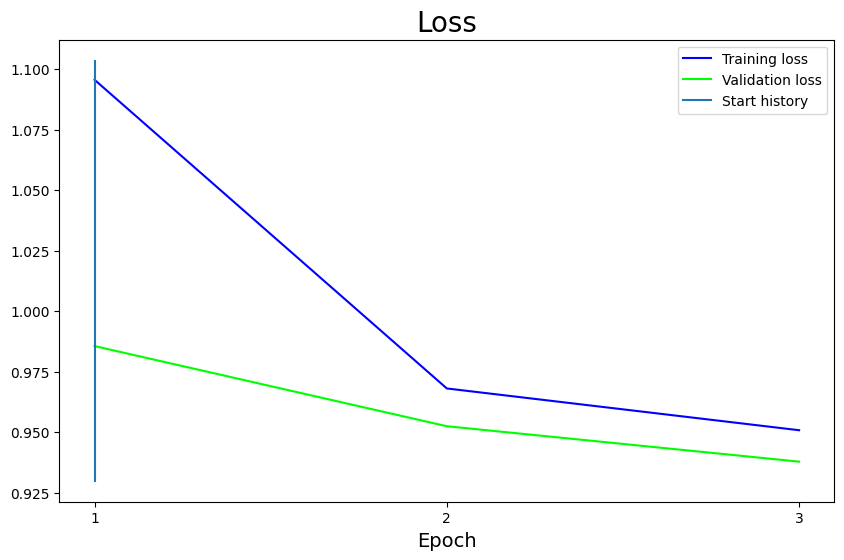

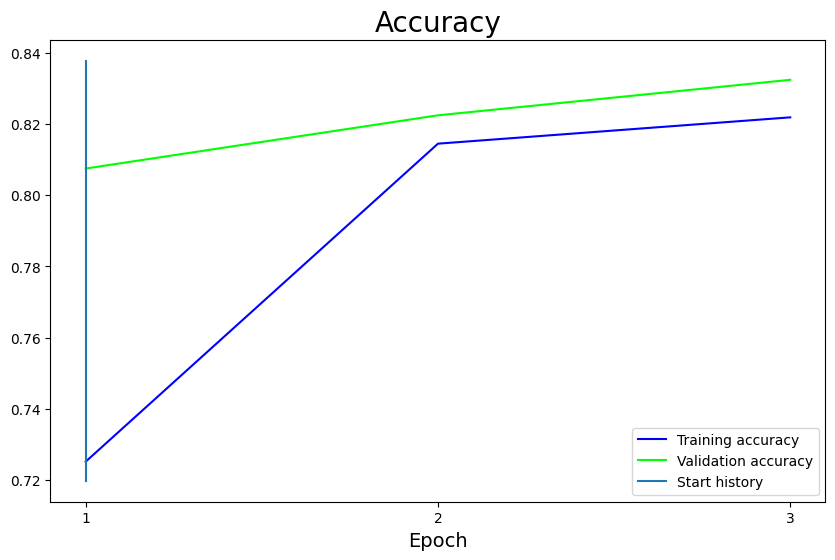

In [112]:
ml_plot.plot_history(history=model_5_history)

In [107]:
# Make preductions with the char token pos model
model_5_pred_props = model_5.predict(val_char_token_pos_dataset, verbose=1)
model_5_pred_props

array([[0.50759304, 0.10403384, 0.01210691, 0.35434   , 0.02192624],
       [0.52905226, 0.11570235, 0.0407817 , 0.3029699 , 0.01149374],
       [0.3098562 , 0.11419706, 0.13129988, 0.37993532, 0.06471154],
       ...,
       [0.03057702, 0.10653517, 0.05008313, 0.02956432, 0.7832404 ],
       [0.03081071, 0.30042797, 0.0619062 , 0.02637785, 0.58047724],
       [0.24164246, 0.54330426, 0.10838617, 0.04154284, 0.06512427]],
      dtype=float32)

In [108]:
# Convert pred probs into pred labels
model_5_preds = tf.argmax(model_5_pred_props, axis=1)
model_5_preds

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([0, 0, 3, ..., 4, 4, 1])>

In [110]:
# Calculate results of char token pos model

# Remember these results are only based on the 20k lines of data, not the 200k lines of data,
# We also train only on 10% of those 20k lines of data (so only 2000 lines in total)

model_5_results = ml_plot.table_quality_metrics(y_true=val_labels_encoded, y_pred=model_5_preds)
model_5_results

{'accuracy': 83.31788693234476,
 'f1': 0.8319216018789132,
 'precision': 0.8321967571847926,
 'recall': 0.8331788693234476}

In [111]:
model_4_results

{'accuracy': 72.7856480868529,
 'f1': 0.7266156568492785,
 'precision': 0.7297875201058328,
 'recall': 0.727856480868529}

## Compare our model results

In [ ]:
all_model_results = pd.DataFrame({
    "model_0_baseline": model_0_results,
    "model_1_custom_token_embedding": model_1_results,
    "model_2_pretrained_token_embedding": model_2_results,
    "model_3_custom_char_embedding": model_3_results,
    "model_4_hybrid_char_token_embedding": model_4_results,
    "model_5_tribrid_char_token_pos_embedding": model_5_results
})

all_model_results = all_model_results.transpose()
all_model_results

In [ ]:
# Reduce accuracy to same scale as other metrics
all_model_results['accuracy'] = all_model_results['accuracy'] / 100

In [ ]:
# Plot and compare all model results
all_model_results.plot(kind="bar", figsize=(10, 7)).legend(bbox=(1.0, 1.0))

In [ ]:
# Sort the model results by f1-scores
all_model_results.sort('f1', ascending=True)['f1'].plot(kind='bar', figsize=(10, 7))

## Save and load the model

In [115]:
# Save the model
ml_layer.save_model(model_5, filepath='./models/model_5.tf', save_format='tf')

In [ ]:
# Load the model
loaded_model = ml_layer.load_model(filepath='./models_model_5.tf', )

In [ ]:
# Make some predictions and compare them
loaded_model_pred_props = loaded_model.predict(val_char_token_pos_dataset)
loaded_model_preds = tf.argmax(loaded_model_pred_props, axis=1)
loaded_model_preds[:10]

In [ ]:
# Calculate results of our loaded model
loaded_model_results = ml_plot.table_quality_metrics(y_true=val_labels_encoded, y_pred=loaded_model_preds)
loaded_model_results

In [ ]:
# Check loaded model summary
loaded_model.summary()

## Download and load in a pretrained model from Google Storage

In [ ]:
# Download the pretrained model
!wget https://storage.googleapis.com/ztm_tf_course/skimlit/skimlit_tribrid_model.zip
ml_io.download_file(source='https://storage.googleapis.com/ztm_tf_course/skimlit/skimlit_tribrid_model.zip', filepath='./skimlit_tribrid_model.zip')
ml_io.extract_zip(filepath='./skimlit_tribrid_model.zip', folder='./data')

In [ ]:
# Load the model
loaded_model = ml_layer.load_model(filepath='./data/skimlit_tribrid_model')

In [ ]:
# Evaluate the loaded model
loaded_model.evaluate(val_char_token_pos_dataset)

## Challanges:

1. Turn the test data samples into a tf.data Dataset (fast loading) (same as train, val), evaluate (make predictions) the best performing model on the test data. (compare to ground truth)
2. Find the most wrong predictions from 1 (these are the samples where the model has predicted the wrong labe with the highest probability)
3. Make example predictions (on RCT abstracts from the wild pubmed.org, search for ... RCT) to find and use our model to predict on three to four different abstracts in the wild. Also check the extras folder in GitHub (https://github.com/mrdbourke/tensorflow-deep-learning/blob/main/extras/skimlit_example_abstracts.json)
4. Perform extra curicullem.

In [ ]:
# Create dataset from test data
test_char_token_pos_data = tf.data.Dataset.from_tensor_slices((test_line_numbers_one_hot,
                                                                test_total_lines_one_hot,
                                                                test_sentences,
                                                                test_chars))

# Create Y
test_char_token_pos_label = tf.data.Dataset.from_tensor_slices(test_labels_one_hot)

# Combine both the X and Y datasets into a new dataset
test_char_token_pos_dataset = tf.data.Dataset.zip((test_char_token_pos_data, test_char_token_pos_label))

In [ ]:
# Make predictions using the test dataset.
loaded_model_pred_props = loaded_model.predict(test_char_token_pos_dataset)
loaded_model_preds = tf.argmax(loaded_model_pred_props, axis=1)

In [ ]:
# Calcualte the model's quality / performance.
loaded_model_results = ml_plot.table_quality_metrics(y_true=test_labels_encoded, y_pred=loaded_model_preds)
loaded_model_results

In [ ]:
# Plot the outliers (false positive and false negative, top 10 on both sides)
ml_plot.show_outliers_positive_and_negative(y_true=test_labels_encoded, y_pred=loaded_model_preds)

In [39]:
ml_io.download_file(source='https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/skimlit_example_abstracts.json', filepath='./data/skimlit_example_abstracts.json')
loaded_df = pd.read_json('./data/skimlit_example_abstracts.json')
loaded_df

Download of https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/skimlit_example_abstracts.json completed.


,abstract,source,details
0,This RCT examined the efficacy of a manualized...,https://pubmed.ncbi.nlm.nih.gov/20232240/,RCT of a manualized social treatment for high-...
1,Postpartum depression (PPD) is the most preval...,https://pubmed.ncbi.nlm.nih.gov/28012571/,Formatting removed (can be used to compare mod...
2,"Mental illness, including depression, anxiety ...",https://pubmed.ncbi.nlm.nih.gov/28942748/,Effect of nutrition on mental health
3,Hepatitis C virus (HCV) and alcoholic liver di...,https://pubmed.ncbi.nlm.nih.gov/22244707/,Baclofen promotes alcohol abstinence in alcoho...


In [40]:
# Add line number and total lines
loaded_df.abstract[1]

"Postpartum depression (PPD) is the most prevalent mood disorder associated with childbirth. No single cause of PPD has been identified, however the increased risk of nutritional deficiencies incurred through the high nutritional requirements of pregnancy may play a role in the pathology of depressive symptoms. Three nutritional interventions have drawn particular interest as possible non-invasive and cost-effective prevention and/or treatment strategies for PPD; omega-3 (n-3) long chain polyunsaturated fatty acids (LCPUFA), vitamin D and overall diet. We searched for meta-analyses of randomised controlled trials (RCT's) of nutritional interventions during the perinatal period with PPD as an outcome, and checked for any trials published subsequently to the meta-analyses. Fish oil: Eleven RCT's of prenatal fish oil supplementation RCT's show null and positive effects on PPD symptoms. Vitamin D: no relevant RCT's were identified, however seven observational studies of maternal vitamin D 

In [41]:
example_df = pd.DataFrame(columns=['line_number', 'text', 'total_lines'])

for a in loaded_df.abstract:
  lines = a.split('. ')
  line_number = 1
  for l in lines:

    pd_to_add = pd.DataFrame.from_records([{
        'line_number': line_number,
        'text': l.strip(),
        'total_lines': len(lines)
    }])

    example_df = pd.concat([example_df, pd_to_add])
    line_number += 1

example_df

,line_number,text,total_lines
0,1,This RCT examined the efficacy of a manualized...,8
0,2,Participants were randomly assigned to treatme...,8
0,3,Treatment included instruction and therapeutic...,8
0,4,A response-cost program was applied to reduce ...,8
0,5,Significant treatment effects were found for f...,8
0,6,Secondary measures based on staff ratings (tre...,8
0,7,"High levels of parent, child and staff satisfa...",8
0,8,Standardized effect size estimates were primar...,8
0,1,Postpartum depression (PPD) is the most preval...,10
0,2,"No single cause of PPD has been identified, ho...",10


In [44]:
# One hot encode the line numbers and total lines
example_line_numbers_one_hot = tf.one_hot(example_df['line_number'].to_numpy(), depth=15)
example_total_lines_one_hot = tf.one_hot(example_df['total_lines'].to_numpy(), depth=20)

# Extract the sentences (for the TextVectorizer)
example_sentences = example_df['text'].to_list()

# Extract the charactes for each sentence
example_chars = [split_chars(sentence) for sentence in example_sentences]

In [46]:
# Create dataset from example data
example_char_token_pos_dataset = tf.data.Dataset.from_tensor_slices((example_line_numbers_one_hot,
                                                                example_total_lines_one_hot,
                                                                example_sentences,
                                                                example_chars))